In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cust_df = pd.read_csv("./customer_df.csv")

In [3]:
cust_df.head()

,CustomerID,recency,frequency,promo,total_basket,avg_basket,std_basket,total_nb_d_items,avg_nb_d_items,std_nb_d_items,total_quantity,avg_quantity,std_quantity
0,12347.0,2,7,0.065934,4310.00,615.714286,341.070789,103,26.000000,11.430952,2458,351.142857,173.277647
1,12348.0,75,4,0.148148,1437.24,359.310000,203.875689,21,6.750000,6.291529,2332,583.000000,474.843132
2,12349.0,18,1,0.000000,1457.55,1457.550000,NaN,72,72.000000,NaN,630,630.000000,NaN
3,12350.0,310,1,0.062500,294.40,294.400000,NaN,16,16.000000,NaN,196,196.000000,NaN
4,12352.0,36,6,0.000000,1265.41,210.901667,81.523397,57,11.666667,5.046451,463,77.166667,37.139826


In [4]:
features_selection = ['recency', 'frequency', 'promo', 'total_basket',
       'avg_basket', 'total_nb_d_items', 'avg_nb_d_items',
       'total_quantity', 'avg_quantity']

X = cust_df.loc[:,features_selection]

## PCA

C:\Users\Mo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys


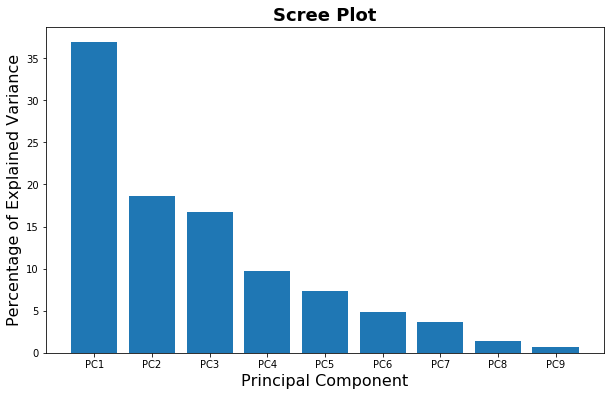

In [5]:
# Perform PCA
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np

# scale inputs
X_scal = preprocessing.scale(X)
X_scal = pd.DataFrame(X_scal,columns=features_selection)

# model
pca = PCA()  # create a PCA object
pca.fit(X_scal)  # do the math

# get PCA coordinates for scaled_data (return nparray)
pca_data = pca.transform(X_scal)

# Draw a scree plot and a PCA plot
per_var = np.round(pca.explained_variance_ratio_[:10] * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(10, 6))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance', size=16)
plt.xlabel('Principal Component', size=16)
plt.title("Scree Plot", size=18, fontweight="bold")
plt.show()

<Figure size 720x720 with 0 Axes>

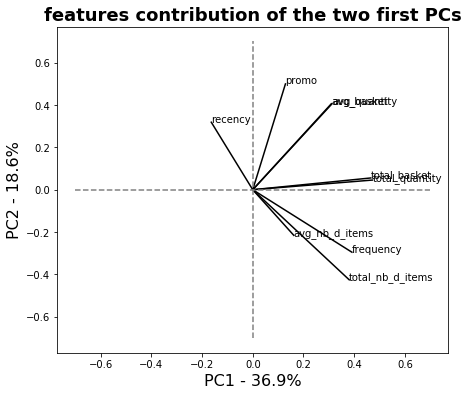

In [6]:
# Movies selection in 2D (PC1-PC2)
plt.figure(figsize=(10, 10))
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.figure(figsize=(7, 6))
# inputs plot 2
pcs = pca.components_

# plot 2
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, features_selection[i], fontsize='10')
    plt.title("features contribution of the two first PCs",
              size=18,
              fontweight="bold")

plt.xlabel('PC1 - {0}%'.format(per_var[0]), size=16)
plt.ylabel('PC2 - {0}%'.format(per_var[1]), size=16)
# Afficher les lignes horizontale y=0 et verticale x=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')
plt.show();

In [8]:
# extraction of first pca_components
pca_components = pd.DataFrame(data= pcs[0, :],
                              index=X.columns,
                              columns=["feat_contrib_PC1"])
pca_components.abs().sort_values(by="feat_contrib_PC1",
                                 ascending= False)

,feat_contrib_PC1
total_quantity,0.471973
total_basket,0.465512
frequency,0.390937
total_nb_d_items,0.380377
avg_quantity,0.312383
avg_basket,0.309717
recency,0.163530
avg_nb_d_items,0.161738
promo,0.128891


Obviously quantity is directly linked with the basket
and "average" and "total" are linked with frequency (total = freq * avg)
Customer ID should not be used

In [9]:
# feature filtering
features_selection2 = pca_components.abs().sort_values(by="feat_contrib_PC1", 
                                 ascending=False).index
features_selection2 = features_selection2.drop(["total_quantity",
                                                "avg_quantity",
                                                "total_basket",
                                                "total_nb_d_items"])
features_selection2

Index(['frequency', 'avg_basket', 'recency', 'avg_nb_d_items', 'promo'], dtype='object')

In [10]:
X_scal = X_scal.loc[:, features_selection2]
X_scal.head()

,frequency,avg_basket,recency,avg_nb_d_items,promo
0,0.366571,0.446164,-0.901216,0.205432,-0.153355
1,-0.030122,-0.028235,-0.173042,-0.758302,0.238878
2,-0.426815,2.003726,-0.741616,2.508380,-0.467917
3,-0.426815,-0.148332,2.171079,-0.295209,-0.169738
4,0.234340,-0.302820,-0.562066,-0.512153,-0.467917


## Kmean

In [12]:
from sklearn.cluster import KMeans
from sklearn import cluster, metrics

# Test of the number of clustering 
min_cluster = 3
max_cluster = 12

silhouettes = []
n_per_groups = []
kmean_centers = []
for num_clusters in range(min_cluster, max_cluster, 1):
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, init="k-means++")
    kmeans.fit(X_scal)
    silh = metrics.silhouette_score(X_scal, kmeans.labels_)
    silhouettes.append(silh)

    # save relvent variable for each runs (centers, number of occurence per clusters)
    kmean_centers.append(kmeans.cluster_centers_)
    n_per_groups.append(pd.value_counts(kmeans.labels_))  # save group repartition
    
    # add group for each customer in the main df
    new_col_name = str(num_clusters) + "_cluster"
    cust_df[new_col_name] = kmeans.labels_ 

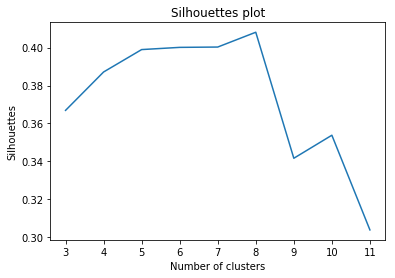

In [13]:
# Silhouette plot

x = list(np.arange(3,12))
y = silhouettes

plt.plot(x, y)
plt.title("Silhouettes plot")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouettes")
plt.show()

High sihouette value for N clusters inbetween 5 and 8. let´s have a look on the distribution of customers on each groups.

In [14]:
# to redisign with graph
n_per_groups

[1    3027
 2     998
 0     299
 dtype: int64, 1    2581
 0     944
 2     520
 3     279
 dtype: int64, 4    2576
 0     935
 1     518
 3     268
 2      27
 dtype: int64, 1    2577
 0     936
 3     518
 5     268
 2      22
 4       3
 dtype: int64, 1    2396
 0     915
 5     511
 2     261
 3     227
 4      11
 6       3
 dtype: int64, 1    2407
 7     915
 0     522
 4     243
 3     202
 2      25
 5       7
 6       3
 dtype: int64, 0    2017
 2     912
 3     797
 1     247
 7     183
 5     139
 8      20
 4       7
 6       2
 dtype: int64, 0    2014
 2     903
 5     729
 8     279
 1     248
 3     107
 7      23
 6      16
 9       3
 4       2
 dtype: int64, 0     1974
 1      614
 5      591
 6      542
 9      280
 2      249
 10      29
 3       25
 4       15
 7        3
 8        2
 dtype: int64]

Above 5 clusters, very small clusters appear (> 20 occurences). we will choose to continue with 5 clusters.

In [16]:
# we choose number of cluster = 5 and number of feature = 4 (to get )
num_clusters = 5

kmeans = KMeans(n_clusters=num_clusters, n_init=10, init="k-means++")
kmeans.fit(X_scal)
silh = metrics.silhouette_score(X_scal, kmeans.labels_)
silh

0.3989585048735571

In [14]:
features_selection2[:nb_features]

Index(['frequency', 'avg_basket', 'avg_nb_d_items', 'recency'], dtype='object')

In [18]:
# extract cluster's centers
km_centers = pd.DataFrame(kmeans.cluster_centers_, columns=X_scal.columns)
km_centers

,frequency,avg_basket,recency,avg_nb_d_items,promo
0,-0.354407,-0.220861,1.560930,-0.276695,-0.187378
1,0.068795,-0.135227,-0.514004,-0.216016,-0.231404
2,0.056223,0.628191,0.201578,-0.799686,3.357582
3,-0.142952,0.507089,-0.332411,1.993349,-0.345248
4,7.893952,4.586006,-0.638172,-0.113752,1.863008


In [26]:
features_selection2

Index(['frequency', 'avg_basket', 'recency', 'avg_nb_d_items', 'promo'], dtype='object')

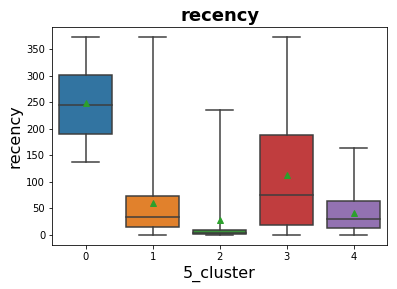

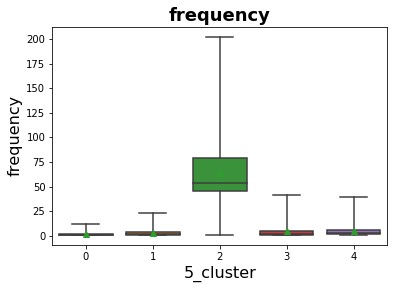

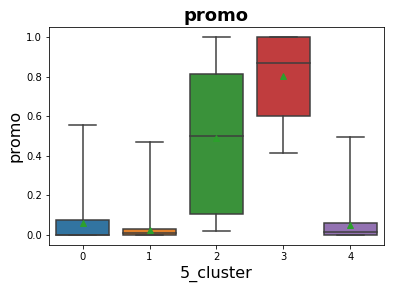

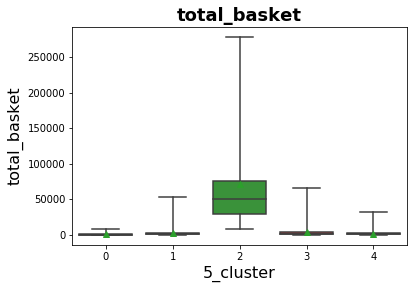

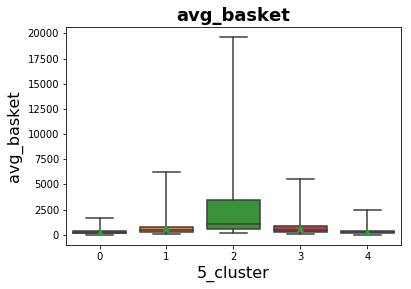

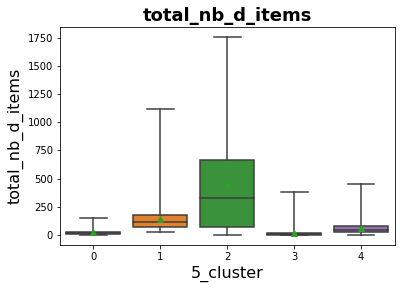

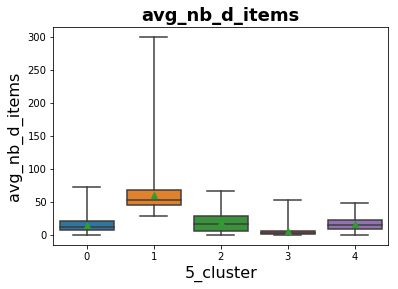

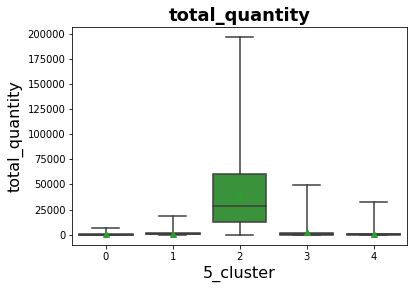

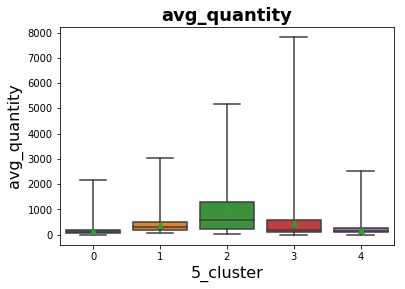

In [29]:
# features boxplot per cluster:
for feature in features_selection:
    plt.figure(figsize=(6, 4))
    plt.title(feature, fontweight="bold", size = 18)
    plt.ylabel(feature, size=16)
    plt.xlabel("cluster", size=16)
    sns.boxplot(x="5_cluster", y=feature, data=cust_df,showmeans=True, whis="range")
    plt.show()

if we try to look for cluster meanings, based on the boxplots aboves, we have:  
- Cluster 0: high recency, group of customer that did not connet for more than 200 days.
- Cluster 1: they are not big customers, but in average by a lot of different items (maybe very small business)
- Cluster 2: good customers, high frequency and high total/avg basket. They also have often some discounts.
- Cluster 3: promo hunters. tend to by only when good promotion are presents.
- Cluster 4: the rest (no extreme behaviours).

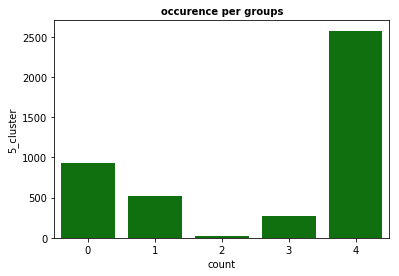

In [48]:
# plot
y = cust_df.groupby(by="5_cluster").aggregate({"5_cluster": len})

plt.figure(figsize=(6, 4))
plt.title("occurence per groups", fontweight="bold", size=10)
sns.barplot(x=y.index, y=y.loc[:, "5_cluster"], label="Total", color="g");
plt.xlabel("count")
plt.show()

In [49]:
cust_df.head()

,CustomerID,recency,frequency,promo,total_basket,avg_basket,std_basket,total_nb_d_items,avg_nb_d_items,std_nb_d_items,...,std_quantity,3_cluster,4_cluster,5_cluster,6_cluster,7_cluster,8_cluster,9_cluster,10_cluster,11_cluster
0,12347.0,2,7,0.065934,4310.00,615.714286,341.070789,103,26.000000,11.430952,...,173.277647,1,1,4,1,1,1,3,0,0
1,12348.0,75,4,0.148148,1437.24,359.310000,203.875689,21,6.750000,6.291529,...,474.843132,1,1,4,1,1,1,0,0,0
2,12349.0,18,1,0.000000,1457.55,1457.550000,NaN,72,72.000000,NaN,...,NaN,1,2,1,3,5,0,5,3,5
3,12350.0,310,1,0.062500,294.40,294.400000,NaN,16,16.000000,NaN,...,NaN,2,0,0,0,0,7,2,2,6
4,12352.0,36,6,0.000000,1265.41,210.901667,81.523397,57,11.666667,5.046451,...,37.139826,1,1,4,1,1,1,0,0,0


In [16]:
y = kmeans.labels_
cust_df.join(pd.DataFrame(y)).sample(30).drop(["CustomerID",
                                              "std_quantity",
                                               "total_quantity",
                                               "std_nb_d_items",
                                               "total_nb_d_items",
                                               "std_basket"], axis=1)

,recency,frequency,promo,total_basket,avg_basket,avg_nb_d_items,avg_quantity,0
3653,239,1,0.000000,167.55,167.550000,33.000000,149.000000,0
2416,19,1,0.019608,611.59,611.590000,51.000000,255.000000,2
520,358,1,0.545455,190.55,190.550000,11.000000,83.000000,0
1876,71,4,0.116883,1268.98,317.245000,19.250000,284.000000,1
3645,25,2,0.022727,384.39,192.195000,22.000000,76.000000,1
3105,5,1,0.857143,90.04,90.040000,7.000000,184.000000,1
1034,54,5,0.250000,1647.26,329.452000,4.800000,103.200000,1
851,312,1,0.055556,316.26,316.260000,18.000000,162.000000,0
2771,60,3,0.000000,709.38,236.460000,12.333333,146.666667,1
4000,107,1,0.000000,51.56,51.560000,5.000000,52.000000,1


In [50]:
pca = PCA()  # create a PCA object
pca.fit(X_scal)  # do the math
labels = ['PC' + str(x) for x in range(1, len(X_scal.columns)+1)]
# get PCA coordinates for scaled_data (return nparray)
pca_data = pca.transform(X_scal)
pca_center = pca.transform(kmeans.cluster_centers_)

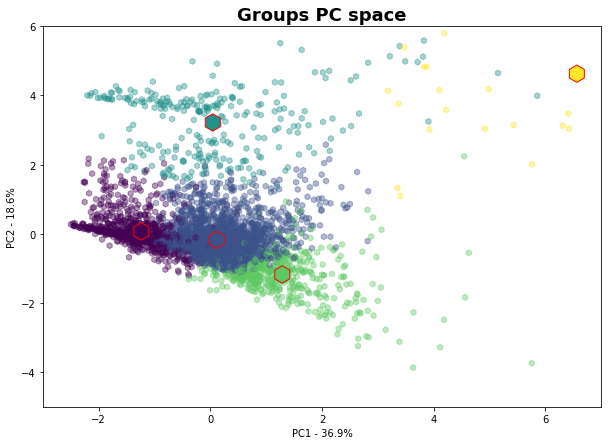

In [59]:
# plot of clusters in PC

# inputs precessing
# dum_var_trans = kmeans.transform(dum_var)
pca_center = pca.transform(kmeans.cluster_centers_)
pca_df_C = pd.DataFrame(pca_center, columns=labels)
pca_df_sample = pd.DataFrame(pca_center, columns=labels)
pca_df_sample = pd.DataFrame(pca_data,
                             columns=labels)
pca_df_sample["cluster"] = kmeans.labels_
# pca_df_sample = pca_df_sample.sample(2000)


# plot
plt.figure(figsize=(10, 7))
plt.scatter(pca_df_sample.PC1,
            pca_df_sample.PC2,
            marker="h",
            c=pca_df_sample["cluster"],
            alpha=0.4)
plt.scatter(pca_df_C.PC1, pca_df_C.PC2, marker="h", c=[0, 1, 2, 3, 4], s=300, alpha=1, edgecolors='red')
plt.title("Groups PC space", size=18, fontweight="bold")
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.xlim([-3, 7])
plt.ylim([-5, 6])
plt.show()

In [60]:
# New feature selection for new customer (need to be present from the fist order):

y = kmeans.labels_
features_selection = ['promo', 'avg_basket', 'avg_nb_d_items', 'avg_quantity']
X = cust_df.loc[:,features_selection]

##  Classification

In [61]:
# split train-test
from sklearn.model_selection import train_test_split

# split the data with 80% in each set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,
train_size=0.8)

C:\Users\Mo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### KNN

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(1,20)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=7)
grid.fit(X_train, y_train)
knn = grid.best_estimator_

In [63]:
grid.best_params_

{'n_neighbors': 11}

In [64]:
grid.best_score_

0.6608846487424112

In [66]:
y_pred = knn.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.6473988439306358

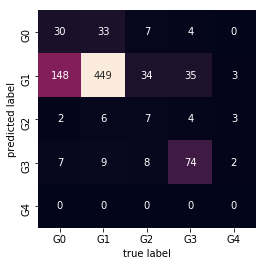

In [67]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
group_names = ["G0","G1","G2","G3","G4"]
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=group_names,
            yticklabels=group_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

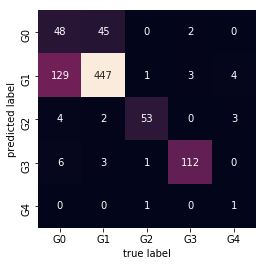

In [83]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
group_names = ["G0","G1","G2","G3","G4"]
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=group_names,
            yticklabels=group_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [84]:
metrics.accuracy_score(y_test, y_pred)

0.7641618497109827

### Multinomial Naive Bayes 

In [71]:
from sklearn.naive_bayes import MultinomialNB
multi_nb = MultinomialNB(alpha=1)
multi_nb.fit(X_train, y_train)
y_pred = multi_nb.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.44971098265895953

### Gaussian Naive Bayes 

In [72]:
from sklearn.naive_bayes import GaussianNB
gauss_nb = GaussianNB()
gauss_nb.fit(X_train, y_train)
y_pred = gauss_nb.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.7271676300578035

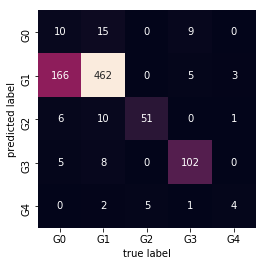

In [73]:
mat = confusion_matrix(y_test, y_pred)
group_names = ["G0","G1","G2","G3","G4"]
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=group_names,
            yticklabels=group_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [74]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.05      0.29      0.09        34
           1       0.93      0.73      0.82       636
           2       0.91      0.75      0.82        68
           3       0.87      0.89      0.88       115
           4       0.50      0.33      0.40        12

   micro avg       0.73      0.73      0.73       865
   macro avg       0.65      0.60      0.60       865
weighted avg       0.88      0.73      0.79       865



### linear SVC

In [75]:
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
metrics.accuracy_score(y_test, y_pred)


C:\Users\Mo\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.22890173410404624

### SVM

In [76]:
from sklearn.svm import SVC

param_grid = {"C": [1, 5, 10, 25],
             "gamma": ["auto", "scale"]}
grid = GridSearchCV(SVC(), param_grid, cv=7)
grid.fit(X_train, y_train)

GridSearchCV(cv=7, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 5, 10, 25], 'gamma': ['auto', 'scale']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [77]:
grid.best_params_

{'C': 1, 'gamma': 'scale'}

In [78]:
grid.best_score_

0.688349233882625

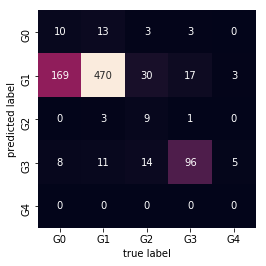

In [79]:
svc = grid.best_estimator_
y_pred = svc.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
group_names = ["G0","G1","G2","G3","G4"]
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=group_names,
            yticklabels=group_names)
plt.xlabel('true label')
plt.ylabel('predicted label');